<a href="https://colab.research.google.com/github/gerfernandez54/ProyFinal-FernandezG/blob/main/ETL_spotify_prueba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 kB 18.8 MB/s eta 0:00:00


In [55]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import json
from google.colab import auth
from googleapiclient.discovery import build
import io

# Configuración de credenciales de Spotify
SPOTIPY_CLIENT_ID = 'b593b6adb5144c88b33624c377943faf'
SPOTIPY_CLIENT_SECRET = '852f367dfffb410bb13a30a65c95e3f5'

# Configurar cliente de Spotify
client_credentials_manager = SpotifyClientCredentials(
    client_id=SPOTIPY_CLIENT_ID,
    client_secret=SPOTIPY_CLIENT_SECRET
)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [72]:
def obtener_datos_artistas(artista):
    """
    Extrae información detallada de un artista de Spotify
    """
    # Extract the ID portion from the full URI
    artist_id = artista.split(':')[2]  # Extract the ID from the URI

    # Obtener datos básicos del artista
    resultados = sp.artist(artist_id)  # Pass only the artist ID

    # Obtener álbumes populares
    albumes = sp.artist_albums(artist_id, country='ES', limit=10)  # Pass only the artist ID

    # Obtener características de audio de las canciones principales
    top_tracks = sp.artist_top_tracks(artist_id)  # Pass only the artist ID

    return {
        'datos_artista': resultados,
        'albumes': albumes,
        'top_tracks': top_tracks
    }

# Lista de artistas populares para analizar
artistas_populares = [

      'spotify:artist:4q3ewBCX7sLwd24euuV69X', # Bud Bunny
      'spotify:artist:0EmeFodog0BfCgMzAIvKQp', # Shakira
      'spotify:artist:1i8SpTcr7yvPOmcqrbnVXY', # OZUNA
      'spotify:artist:790FomKkXshlbRYZFtlgla', # Karol G


]

datos_raw = []
for artista_id in artistas_populares:
    datos = obtener_datos_artistas(artista_id)
    datos_raw.append(datos)


In [73]:
def transformar_datos(datos_raw):
    """
    Transforma los datos crudos en un DataFrame estructurado
    """
    registros_transformados = []

    for dato_artista in datos_raw:
        artista = dato_artista['datos_artista']

        registro_base = {
            'nombre': artista['name'],
            'seguidores': artista['followers']['total'],
            'generos': ','.join(artista['genres']),
            'popularidad': artista['popularity']
        }

        # Agregar información de álbumes
        for album in dato_artista['albumes']['items']:
            registro_album = registro_base.copy()
            registro_album.update({
                'tipo': 'album',
                'titulo_album': album['name'],
                'fecha_lanzamiento': album['release_date']
                                          })
            registros_transformados.append(registro_album)

        # Agregar información de canciones principales
        for track in dato_artista['top_tracks']['tracks']:
            registro_cancion = registro_base.copy()
            registro_cancion.update({
                'tipo': 'track',
                'titulo_cancion': track['name'],
                'numero_reproducciones': None  # Spotify no proporciona esta métrica directamente
            })
            registros_transformados.append(registro_cancion)

    return pd.DataFrame(registros_transformados)

# Aplicar la transformación
df_transformado = transformar_datos(datos_raw)

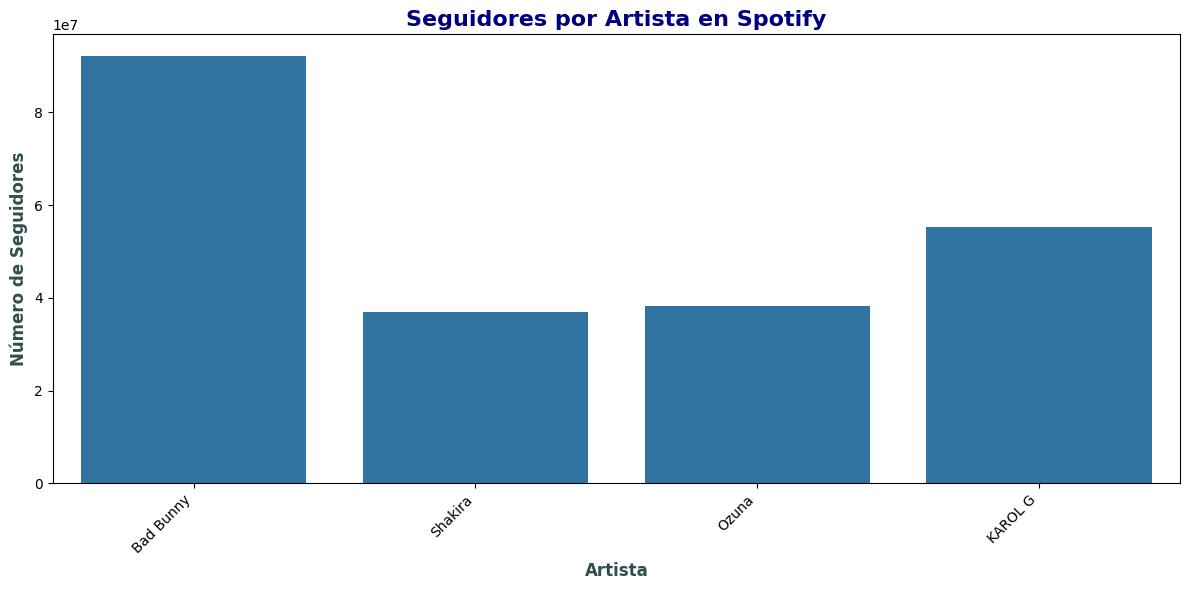


Estadísticas generales:
           seguidores  tipo
nombre                     
Bad Bunny  92221070.0    40
KAROL G    55331326.0    20
Ozuna      38234785.0    20
Shakira    37059590.0    20


In [71]:
# Guardar datos en CSV
df_transformado.to_csv('datos_spotify.csv', index=False)

# Visualización básica de los datos
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=df_transformado, x='nombre', y='seguidores')
plt.title('Seguidores por Artista en Spotify', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Artista', fontsize=12, fontweight='bold', color='darkslategray')
plt.ylabel('Número de Seguidores', fontsize=12, fontweight='bold', color='darkslategray')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


# Estadísticas básicas
print("\nEstadísticas generales:")
print(df_transformado.groupby('nombre').agg({
    'seguidores': 'mean',
    'tipo': 'count'
}).round(2))